In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np
plt.style.use('ggplot')

# This disables (the all-too-often falsely triggered) 'SettingWithCopyWarning'
pd.options.mode.chained_assignment = None # we promise we'll be careful

print "pandas:",pd.version.short_version
print "numpy:",np.version.short_version

pandas: 0.16.2
numpy: 1.8.2


In [2]:
conn = sqlite3.connect('prath.sqlite')
prath = pd.read_sql_query("select image_id,pixel_index,skin,r,g,b from pixels",conn)

# index the dataframe by image_id and pixel_index for easier access and conversion to images
prath.set_index(['image_id','pixel_index'],inplace=True)
prath.sortlevel(inplace=True)
prath.head()

skin    r    g    b
image_id pixel_index                     
0        0               0  210  205  202
         1               0  211  206  203
         2               0  213  208  205
         3               0  216  211  208
         4               0  219  214  211

In [3]:
images = pd.read_sql("select * from images",conn,index_col='file_name')
images.head()

,image_id,width,height
file_name,,,
sri-lankan-actress-Natasha-Perera-,0,286,400
Megan-Fox-Pretty-Face-1-1024x768,1,512,384
Kishani_-__n_-_5,2,239,320
yamuna_erandathi,3,276,400
pg42RF,4,300,362


In [4]:
conn.close() # we're done loading data

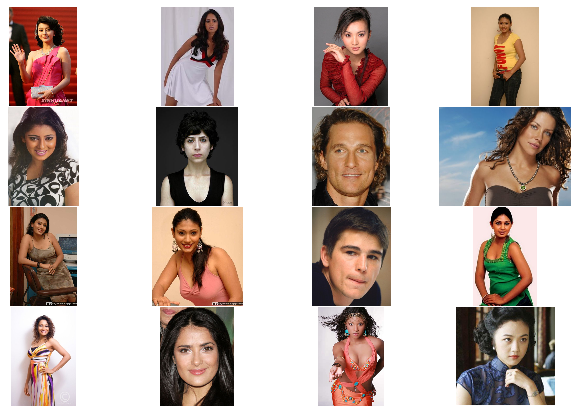

In [5]:
fig, axes = plt.subplots(4,4,subplot_kw=dict(xticks=[],yticks=[]))
sample_images = np.random.choice(images.index.values,16,replace=False)

for fn,ax in zip(sample_images,axes.ravel()):
    img_id,w,h = images.loc[fn]
    df = prath.loc[(img_id,),'r':'b'].astype(np.uint8)
    
    ax.imshow(df.values.reshape(h,w,3))
    
fig.tight_layout()
fig.set_size_inches(fig.get_size_inches()[0]*1.5, fig.get_size_inches()[1]*1.5)
fig.subplots_adjust(wspace=0,hspace=0)

# Let's do a logit fit on the RGB prath dataset

In [6]:
from StringIO import StringIO
def report(y,predy):
    '''A simple report generator for evaluating model accuracy'''
    ret = StringIO()
    acc = np.sum(y == predy)
    fn = np.sum((y != predy) & (y == True))
    fp = np.sum((y != predy) & (y == False))
    dispstr = lambda l,m: "%s: %d/%d (%.3f%%)" % (l,m,y.shape[0],100.0*m/y.shape[0])
    print >> ret, dispstr("Accuracy", acc)
    print >> ret, dispstr("FN", fn)
    print >> ret, dispstr("FP", fp)
    return ret.getvalue()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

clf_rgb = LogisticRegression(C=1e-3)
prath['r2'] = prath['r']**2
prath['g2'] = prath['g']**2
prath['b2'] = prath['b']**2
train, test = train_test_split(prath,train_size=0.5)

get_rgb_features = lambda df: df.loc[:,'r':'b2']

print clf_rgb.fit(get_rgb_features(train),train['skin'])
print report(test.skin, clf_rgb.predict(get_rgb_features(test)))

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Accuracy: 2187240/2956654 (73.977%)
FN: 530492/2956654 (17.942%)
FP: 238922/2956654 (8.081%)



# Let's try to test the classifier on an example image...

In [8]:
def plot_thresh(img,predimg,mask):
    '''Display the results of applying a skin pixel classifier to an image'''
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,subplot_kw=dict(xticks=[],yticks=[]))
    
    ax1.imshow(img)
    ax2.imshow(predimg,interpolation='nearest',cmap='gray')
    ax2.set_title('backprojection')
    threshimg = np.zeros_like(img)
    threshimg[predimg >= 0.5] = 255
    ax3.imshow(threshimg)
    ax3.set_title('threshold')
    ax4.imshow(mask,interpolation='nearest',cmap='gray')
    ax4.set_title('ground truth')

In [9]:
def get_image(fn):
    '''Helper function to get an rgb image from its name'''
    if isinstance(fn,basestring):
        img_id,w,h = images.loc[fn]
    else:
        img_id,w,h = images[images.image_id==fn].iloc[0]
    df = prath.loc[(img_id,),:]
    
    # the .values property is not totally dependable. But it works in this instance
    blocks = df.loc[:,'r':'b']
    img = blocks.values.astype(np.uint8).reshape(h,w,3)
    
    return df,img

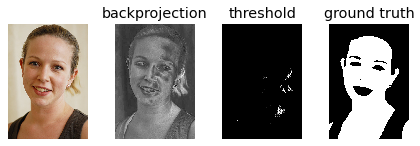

In [10]:
buffydf, buffy = get_image('06Apr03Face')
buffydf['r2'] = buffydf['r']**2
buffydf['g2'] = buffydf['g']**2
buffydf['b2'] = buffydf['b']**2

pred = clf_rgb.predict_proba(get_rgb_features(buffydf))[:,1] # select only the skin=True probability
predimg = pred.reshape(buffy.shape[:2])
mask = buffydf['skin'] == 1

plot_thresh(buffy,predimg,mask.reshape(buffy.shape[:2]))

plt.gcf().tight_layout()

# Let's explore skin pixels in the YCrCb colorspace

In [11]:
def add_crcb(df):
    # grabbed from http://www.equasys.de/colorconversion.html
    df['Y'] =   0.299  *df['r'] + 0.587  *df['g'] + 0.114  *df['b']
    df['Cr'] =  0.5    *df['r'] - 0.419  *df['g'] - 0.081  *df['b'] + 128
    df['Cb'] = -0.169  *df['r'] - 0.331  *df['g'] + 0.5    *df['b'] + 128
add_crcb(prath)

In [12]:
def plot_density(df=None,colorbar=True,H=None,**kwargs):
    if H is None:
        H, xedges, yedges = np.histogram2d(df['Cr'].values, df['Cb'].values,bins=np.arange(0,257))
    else:
        xedges = yedges = np.arange(257)

    # flip the histogram axes so plot displays CrCb values propery
    Hp = H.T
    
    ax = plt.gca()
    fig= plt.gcf()
    mesh = ax.pcolormesh(xedges,yedges,np.ma.masked_where(Hp == 0,Hp,copy=False),**kwargs)

    if colorbar: cbar = fig.colorbar(mesh)
    ax.set_xlabel('Cr')
    ax.set_ylabel('Cb')
    ax.set_xlim(115,205)
    ax.set_ylim(70,145);
    ax.grid()
    
    return H

Uniquely seperable skin/non-skin pixels: 
	10.61 %
Majority Thresholding classifier
	Accuracy: 4361413/5978842 (72.947%)
	FN: 1551894/5978842 (25.956%)
	FP: 0/5978842 (0.000%)
	


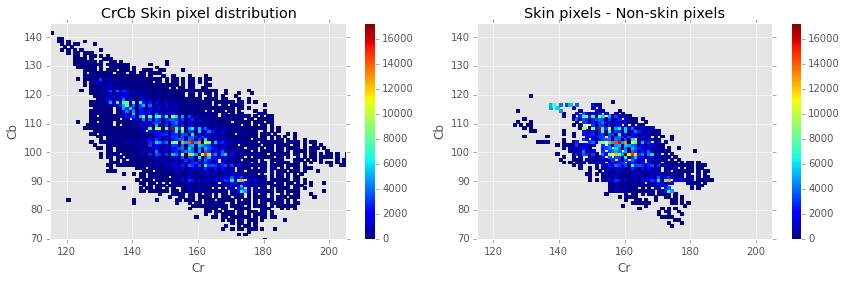

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2)

plt.sca(ax1)
ax1.set_title('CrCb Skin pixel distribution')

# be nice to numpy and give it a singly indexed dataframe
Hs = plot_density(prath[prath.skin==1])

# note: we add 1 extra bin to the histogram to avoid binning together values of 254 and 255 
#(see notes on numpy doc http://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html)
Hns, xedges, yedges = np.histogram2d(prath[prath.skin==0]['Cr'].values, prath[prath.skin==0]['Cb'].values,bins=np.arange(257))
Hdiff = Hs-Hns

plt.sca(ax2)
ax2.set_title('Skin pixels - Non-skin pixels')
plot_density(H=np.ma.masked_where(Hdiff < 0, Hs, copy=True))

fig.set_size_inches(fig.get_size_inches()[0]*2, fig.get_size_inches()[1])
fig.tight_layout()

print "Uniquely seperable skin/non-skin pixels: \n\t%.2f %%" % (100*(np.sum(Hs[Hns==0]) + np.sum(Hns[Hs==0]))/len(prath))

# Create a dataframe with the counts for each CrCb value
crcbspace = np.mgrid[:256,:256].T.reshape(-1,2)
counts = pd.DataFrame(np.hstack((crcbspace,Hdiff.T.reshape(-1,1))),columns=['Cr','Cb','n'])
merged = prath.merge(counts,on=['Cr','Cb'],how='outer')
print "Majority Thresholding classifier"
print "\t"+"\n\t".join(report(merged.skin,merged.n >= 0).split("\n"))

> The plot above empirically shows that only a small minority (~10.6%) of pixels
  in the CrCb pixels can be uniquely separated into skin and non-skin
  pixels. It's also shown that if we were to build a rudimentary classifier,
  assigning category based on a majority vote of skin and non-skin pixels for
  that value, we could achieve a classification accuracy of about 87%.

# Let's try fitting a logit model to the CrCb skin pixels

In [14]:
prath['Cr2'] = prath['Cr']**2
prath['Cb2'] = prath['Cb']**2
prath['CrCb'] = prath['Cr']*prath['Cb']

clf_crcb = LogisticRegression(C=1)
train, test = train_test_split(prath,train_size=0.5)

get_ycc_features = lambda df: df.loc[:,'Cr':'CrCb']

print clf_crcb.fit(get_ycc_features(train),train.skin)
print report(test.skin, clf_crcb.predict(get_ycc_features(test)))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Accuracy: 2376592/2956654 (80.381%)
FN: 308338/2956654 (10.429%)
FP: 271724/2956654 (9.190%)



### Let's see how it performs on our test image.

In [15]:
add_crcb(buffydf)
buffydf['Cr2'] = buffydf['Cr']**2
buffydf['Cb2'] = buffydf['Cb']**2
buffydf['CrCb'] = buffydf['Cr']*buffydf['Cb']

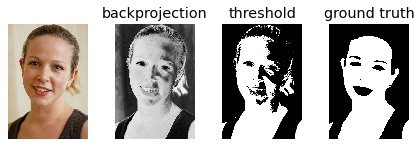

In [16]:
pred = clf_crcb.predict_proba(get_ycc_features(buffydf))[:,1] # select only the skin=True probability
predimg = pred.reshape(buffy.shape[:2])

plot_thresh(buffy,predimg,(buffydf['skin'] == 1).reshape(buffy.shape[:2]))
plt.gcf().tight_layout()

In [36]:
hard_thresh = [(150,180),(85,115)]
def skinthresh(ds,thresh):
    (cr_lo,cr_hi),(cb_lo,cb_hi) = thresh
    return (cr_lo <= ds['Cr']) & (ds['Cr'] <= cr_hi) & (cb_lo <= ds['Cb']) & (cb_hi <= ds['Cb'])
pred = skinthresh(test,hard_thresh)
print report(test.skin, pred)

Accuracy: 2141119/2956654 (72.417%)
FN: 769001/2956654 (26.009%)
FP: 46534/2956654 (1.574%)



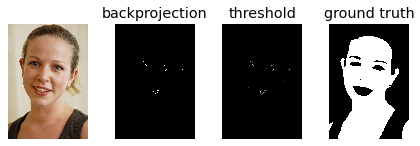

In [33]:
predimg = skinthresh(buffydf,hard_thresh).reshape(buffy.shape[:2])
plot_thresh(buffy,predimg,(buffydf['skin'] == 1).reshape(buffy.shape[:2]))
plt.gcf().tight_layout()

### Let's look at the decision boundary

In [19]:
def decision_bound(clf,X,y,n=1000):
    theta = np.array(list(clf.intercept_) + list(clf.coef_.ravel()))
    subset = np.random.choice(X.index.values,n,replace=False)
    
    X,y = X.ix[subset], y.ix[subset]
    mask = y == 1

    plt.plot(X['Cr'][mask],X['Cb'][mask],'o',label='Skin',alpha=0.8)
    plt.plot(X['Cr'][~mask],X['Cb'][~mask],'o',label='NonSkin',alpha=0.1)

    plt.gca().set_xlabel('Cr')
    plt.gca().set_ylabel('Cb')
    plt.gca().set_xlim(115,205)
    plt.gca().set_ylim(70,145)
    plt.grid(True)

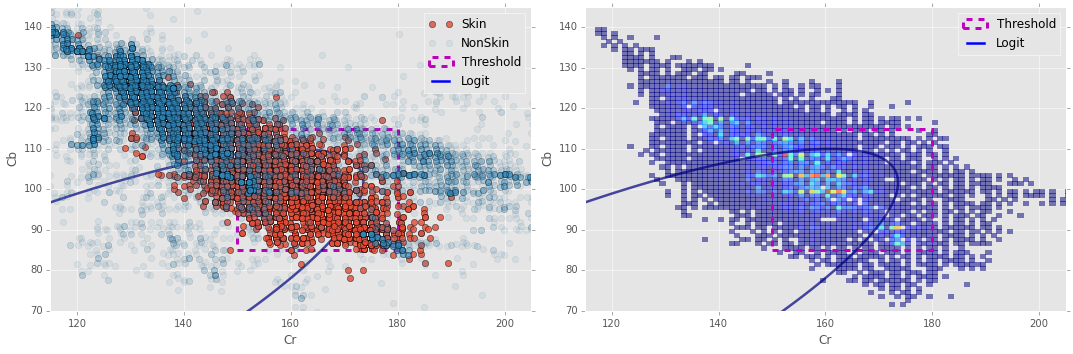

In [37]:
fig,(ax1,ax2) = plt.subplots(1,2)

N = 1000 # sqrt of the number of points to use for the grid
theta = clf_crcb.coef_.ravel()

# evaluate the decision function over a (sparse) grid of points
cr = np.linspace(np.min(prath['Cr']),np.max(prath['Cr']),N).reshape(1,N)
cb = np.linspace(np.min(prath['Cb']),np.max(prath['Cb']),N).reshape(N,1)
z = theta[0]*cr + theta[1]*cb + theta[2]*cr**2 + theta[3]*cb**2 + theta[4]*cr*cb + clf_crcb.intercept_

plt.sca(ax1)
decision_bound(clf_crcb,train.loc[:,'Cr':'Cb'],train.skin,n=30000)
ax1.contour(cr.ravel(),cb.ravel(),z,[0],label='Logit',linewidths=2.5,alpha=0.7)

plt.sca(ax2)
plot_density(train[train.skin == 1],alpha=0.5,colorbar=False)
ax2.contour(cr.ravel(),cb.ravel(),z,[0],label='Logit',linewidths=2.5,alpha=0.7)

x1 = np.array(hard_thresh[0])
x2 = np.array(hard_thresh[1])
ax1.add_patch(plt.Rectangle([x1[0],x2[0]],x1[1]-x1[0],x2[1]-x2[0],fill=False,ls='dashed',lw=3,color='m',label='Threshold'))
ax2.add_patch(plt.Rectangle([x1[0],x2[0]],x1[1]-x1[0],x2[1]-x2[0],fill=False,ls='dashed',lw=3,color='m',label='Threshold'))

line_proxy = plt.Line2D([],[],color='b',ls='solid',lw=2.5)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles+[line_proxy],labels+['Logit'])

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles+[line_proxy],labels+['Logit'])

fig.set_size_inches(fig.get_size_inches()[0]*2.5, fig.get_size_inches()[1]*1.25)
fig.tight_layout()

# Let's explore a few different skin profiles

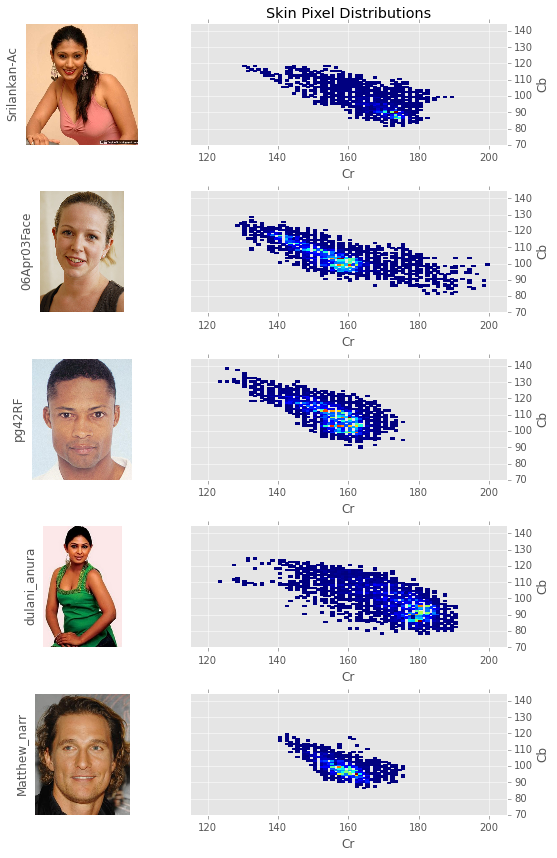

In [21]:
sample_images = ['Srilankan-Actress-Yamuna-Erandathi-001','06Apr03Face','pg42RF','dulani_anuradha4','Matthew_narrowweb__300x381,0']

fig, axes = plt.subplots(len(sample_images),2)
for fn,(ax1,ax2) in zip(sample_images,axes):
    df,img = get_image(fn)
    add_crcb(df)

    ax1.imshow(img)
    ax1.grid(False);ax1.set_xticks([]),ax1.set_yticks([])
    ax1.set_ylabel(fn[:12])
    
    plt.sca(ax2)
    plot_density(df[df.skin == 1],colorbar=False)
    ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right")
    
axes.item(1).set_title('Skin Pixel Distributions')
fig.set_size_inches(fig.get_size_inches()[0]*1.5, fig.get_size_inches()[0]*2)
fig.tight_layout()
from sklearn.cluster import KMeans

n_clusters=4
km = KMeans(n_clusters=n_clusters,n_init=8,n_jobs=-1)

skin = prath.loc[prath.skin==1,:]
km.fit(skin.loc[:,'Cr':'Cb'])
skin['cluster'] = km.labels_

Cluster #0 = [ 150.85660996  107.708975  ]
Cluster #1 = [ 139.21217822  117.20015359]
Cluster #2 = [ 171.8830747   91.7016004]
Cluster #3 = [ 160.39891208  100.70770297]


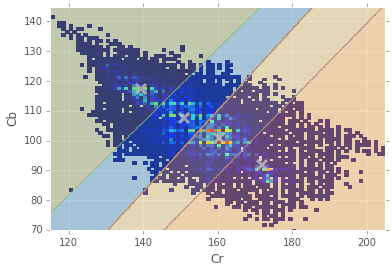

In [23]:
cr = np.linspace(np.min(prath['Cr']),np.max(prath['Cr']),N)
cb = np.linspace(np.min(prath['Cb']),np.max(prath['Cb']),N)

# evaluate the labels over a grid
xx, yy = np.meshgrid(cr,cb)
z = km.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
z = z.reshape(xx.shape)
plot_density(skin,colorbar=False)
plt.contourf(xx,yy,z,cmap=plt.cm.Paired,alpha=0.4)
centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=100, linewidths=3,
            color='0.75',alpha=0.8)
for i,mean in enumerate(centroids): print "Cluster #{} = {}".format(i,mean)

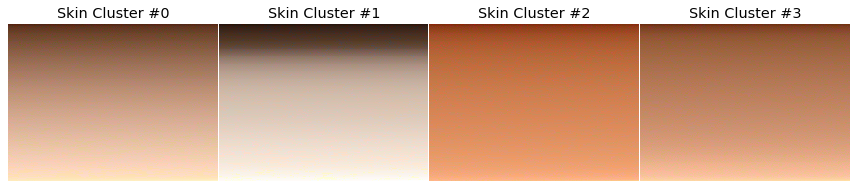

In [24]:
pshape=[180,240]

fig,axes = plt.subplots(1,n_clusters,subplot_kw=dict(xticks=[],yticks=[]))
for i,ax in enumerate(axes):
    plt.sca(ax)
    
    clusterp = skin[skin['cluster'] == i]
    rsamp = np.random.choice(clusterp.index.values,np.product(pshape),replace=False)
    patch = clusterp.ix[rsamp]
    
    patch = patch.sort(columns=['Y']) #sort by luminance value 'Y' for display purposes
    
    imgpatch = patch.loc[:,'r':'b'].values.reshape(pshape+[3]).astype(np.uint8)
    
    ax.imshow(imgpatch,interpolation='nearest')
    ax.grid(False)
    ax.set_title('Skin Cluster #%d' % i)
    
fig.set_size_inches(fig.get_size_inches()[0]*2, fig.get_size_inches()[1]*2)
fig.tight_layout()
fig.subplots_adjust(wspace=0)

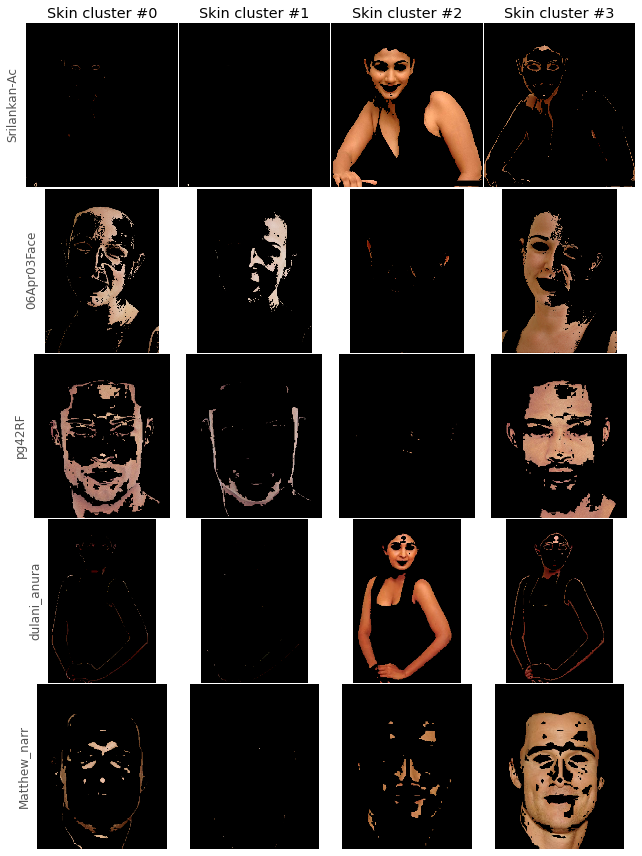

In [25]:
sample_images = ['Srilankan-Actress-Yamuna-Erandathi-001','06Apr03Face','pg42RF','dulani_anuradha4','Matthew_narrowweb__300x381,0']

fig, axes = plt.subplots(len(sample_images),n_clusters,subplot_kw=dict(xticks=[],yticks=[]))
for fn,subaxes in zip(sample_images,axes):
    imgid,w,h = images.loc[fn]
    
    df = prath.loc[(imgid,),'r':'b']
    skindf = skin.loc[(imgid,),'cluster']
    df = df.join(skindf,how='left') # join skin cluster labels with rgb pixels

    cluster = df.cluster
    df.drop('cluster',inplace=True,axis=1)
    
    for i,ax in enumerate(subaxes):
        img = df.copy()
        img[cluster != i] = 0    
        ax.imshow(img.values.reshape(h,w,3).astype(np.uint8))
        if (i % n_clusters) == 0: ax.set_ylabel(fn[:12])
        
        ax.grid(False)

for i in range(n_clusters):
    axes.item(i).set_title('Skin cluster #%d' % i)

fig.set_size_inches(fig.get_size_inches()[0]*1.5, fig.get_size_inches()[0]*2)
fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)